<a href="https://colab.research.google.com/github/Nefarian1/STQD6324-Data-Management-work/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STQD6324 Assignment2 Pan Zhangyu p136922

#Introduce
Have you ever found yourself stranded in an airport due to a delayed or cancelled flight,
pondering if the situation could have been anticipated? This project offers an opportunity to
explore such scenarios.

In this project, you will use data from Kaggle: https://tinyurl.com/u8rzvdsx, encompassing
airline performance data from 1995 to 2007. Each participant need to choose only one year
for analysis.

The challenge:
Find answers to the following questions based on the data available on the website:
+ a. What are the optimal times of day, days of the week, and times of the year for
minimizing flight delays?
+ b. What are the primary factors contributing to flight delays?
+ c. What factors predominantly lead to flight cancellations?
+ d. Which flight experiences the most frequent and significant delays and cancellations?

For each question, utilize Pig or Hive to extract insights from the dataset and generate figures
to explain your findings using Python or R. Please use your creativity to answer these
questions, and you are encouraged to search online for ideas of how others have tackled
similar challenges, such as on this link: https://tinyurl.com/bdejna9e.

Please ensure that the scripts and codes used to generate your findings are included within
the main report. You can use the Google Colab for this purpose. The submission deadline is
May 31, 2024. Please share your work through GitHub.


#illustrate🤓🤓🤓
The data I was originally assigned was 2003.csv, but except for the data from 2004 to 2008, the five columns of CarrierDelay,
WeatherDelay,NASDelay,SecurityDelay, and LateAircraftDelay all had problems, all of which were NA values. So I chose 2006.csv.

#My Files Location🤓🤓🤓
The files I need are all in the Github homepage. Here is the corresponding link: https://github.com/Nefarian1/STQD6324-Data-Management-work/tree/10f5ecdcf66b067f162b7ac2452660f4a3445d14/assignment2

#Ambari PIG
#The following is the code I made using tools such as ambari, virtualBox, and puTTY. These files and codes can be found from the Github link I provided above. The code is as follows:

#assignment2_pzy_code_pig

在puTTY的文件夹位置放一个官网下的pscp.exe（Put pscp.exe from the official website in the folder location of puTTY）

win+R cmd

C:\ProgramData\Microsoft\Windows\Start Menu\Programs\PuTTY (64-bit)


cd C:\ProgramData\Microsoft\Windows\Start Menu\Programs\PuTTY (64-bit)


pscp -P 2222 "C:\Users\PC 15\Desktop\2003.csv" maria_dev@127.0.0.1:2003.csv


password is : maria_dev


My own file location：


pscp -P 2222 "E:\HDP\files\2006.csv" maria_dev@127.0.0.1:2006.csv


puTTY：


hadoop fs -mkdir ml-100k


ls


hadoop fs -copyFromLocal 2006.csv ml-100k/2006.csv


An example of intercepting the first 100,000 lines, which is not used, is shown here：


head -n 100000 2006.csv > t_2006.csv


Upload：


hadoop fs -copyFromLocal t_2006.csv ml-100k/t_2006.csv


ls

Ambari Hive View

Upload from HDFS

path：


/user/maria_dev/ml-100k/2006.csv

row：


Year,Month,DayofMonth,DayOfWeek,DepTime,
CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,
TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,
DepDelay,Origin,Dest,Distance,TaxiIn,
TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,
WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay

#pig

-- 我用的是pig， 因为hive views在文件导入的过程出现问题，可能是不支持太大的文件（权限问题）


-- I use Pig because Hive Views has problems importing files. It may be that it does not support files that are too large (permission issue).


-- a 找出最优的航班延误时间段 Find the optimal flight delay time period


flights = LOAD '/user/maria_dev/ml-100k/2006.csv'
    USING PigStorage(',')
    AS (Year:int, Month:int, DayofMonth:int, DayOfWeek:int, DepTime:chararray, CRSDepTime:int,
        ArrTime:chararray, CRSArrTime:int, UniqueCarrier:chararray, FlightNum:int, TailNum:chararray,
        ActualElapsedTime:int, CRSElapsedTime:int, AirTime:int, ArrDelay:int, DepDelay:int,
        Origin:chararray, Dest:chararray, Distance:int, TaxiIn:int, TaxiOut:int,
        Cancelled:int, CancellationCode:chararray, Diverted:int,
        CarrierDelay:int, WeatherDelay:int, NASDelay:int, SecurityDelay:int, LateAircraftDelay:int);


-- 过滤掉取消的航班 Filter out cancelled flights


flights_filtered = FILTER flights BY Cancelled == 0;


-- 提取小时数并转换为整数，忽略非数字DepTime Extract the hours and convert to integer, ignoring non-numeric DepTime


valid_flights = FILTER flights_filtered BY (DepTime matches '\\d+');
flights_with_hour = FOREACH valid_flights GENERATE
    (int)(SUBSTRING(DepTime, 0, 2)) AS Hour,
    ArrDelay;


-- 按时间分组计算平均延误 Calculate average delay by time group


group_by_hour = GROUP flights_with_hour BY Hour;
avg_delay_by_hour = FOREACH group_by_hour GENERATE
    group AS Hour,
    AVG(flights_with_hour.ArrDelay) AS AvgArrDelay;


-- 按星期几分组计算平均延误 Average delays by day of the week


group_by_dow = GROUP flights_filtered BY DayOfWeek;
avg_delay_by_dow = FOREACH group_by_dow GENERATE
    group AS DayOfWeek,
    AVG(flights_filtered.ArrDelay) AS AvgArrDelay;


-- 按月份分组计算平均延误 Average delays by month


group_by_month = GROUP flights_filtered BY Month;
avg_delay_by_month = FOREACH group_by_month GENERATE
    group AS Month,
    AVG(flights_filtered.ArrDelay) AS AvgArrDelay;


-- 将结果存储到HDFS Store the results in HDFS


STORE avg_delay_by_hour INTO '/user/maria_dev/ml-100k/output_avg_delay_by_hour'
    USING PigStorage(',');
STORE avg_delay_by_dow INTO '/user/maria_dev/ml-100k/output_avg_delay_by_dow'
    USING PigStorage(',');
STORE avg_delay_by_month INTO '/user/maria_dev/ml-100k/output_avg_delay_by_month'
    USING PigStorage(',');





-- b 找出航班延误的主要因素 Find out the main factors causing flight delays


flights = LOAD '/user/maria_dev/ml-100k/2006.csv'
    USING PigStorage(',')
    AS (Year:int, Month:int, DayofMonth:int, DayOfWeek:int, DepTime:chararray, CRSDepTime:int,
        ArrTime:chararray, CRSArrTime:int, UniqueCarrier:chararray, FlightNum:int, TailNum:chararray,
        ActualElapsedTime:int, CRSElapsedTime:int, AirTime:int, ArrDelay:int, DepDelay:int,
        Origin:chararray, Dest:chararray, Distance:int, TaxiIn:int, TaxiOut:int,
        Cancelled:int, CancellationCode:chararray, Diverted:int,
        CarrierDelay:int, WeatherDelay:int, NASDelay:int, SecurityDelay:int, LateAircraftDelay:int);


-- 过滤掉取消的航班 Filter out cancelled flights


flights_filtered = FILTER flights BY Cancelled == 0;


-- 分别计数五种延误类型的延误时间大于零的记录数 Count the number of records with delay time greater than zero for each of the five delay types


carrier_delay_count = FILTER flights_filtered BY CarrierDelay > 0;
weather_delay_count = FILTER flights_filtered BY WeatherDelay > 0;
nas_delay_count = FILTER flights_filtered BY NASDelay > 0;
security_delay_count = FILTER flights_filtered BY SecurityDelay > 0;
late_aircraft_delay_count = FILTER flights_filtered BY LateAircraftDelay > 0;


-- 为每种延误类型添加标签 Add labels for each delay type


carrier_delay_count_labeled = FOREACH carrier_delay_count GENERATE 'CarrierDelay' AS delay_type, 1 AS count;
weather_delay_count_labeled = FOREACH weather_delay_count GENERATE 'WeatherDelay' AS delay_type, 1 AS count;
nas_delay_count_labeled = FOREACH nas_delay_count GENERATE 'NASDelay' AS delay_type, 1 AS count;
security_delay_count_labeled = FOREACH security_delay_count GENERATE 'SecurityDelay' AS delay_type, 1 AS count;
late_aircraft_delay_count_labeled = FOREACH late_aircraft_delay_count GENERATE 'LateAircraftDelay' AS delay_type, 1 AS count;


-- 合并所有延误类型的记录并计数 Merge all delay types and count them


all_delay_count = UNION carrier_delay_count_labeled, weather_delay_count_labeled, nas_delay_count_labeled, security_delay_count_labeled, late_aircraft_delay_count_labeled;


-- 按照延误类型进行分组并计数 Group and count by delay type


grouped_delay_count = GROUP all_delay_count BY delay_type;


-- 计算每种延误类型的总计数 Calculate the total count for each delay type


total_delay_count = FOREACH grouped_delay_count GENERATE group AS delay_type, SUM(all_delay_count.count) AS total_count;


-- 按照延误数量从大到小排序 Sort by delay number from largest to smallest


sorted_delay_count = ORDER total_delay_count BY total_count DESC;


-- 存储结果 Storing Results


STORE sorted_delay_count INTO '/user/maria_dev/ml-100k/output_delay_counts_labeled' USING PigStorage(',');




-- c 找出航班取消的主要因素 Find out the main reasons for flight cancellations


flights = LOAD '/user/maria_dev/ml-100k/2006.csv'
    USING PigStorage(',')
    AS (Year:int, Month:int, DayofMonth:int, DayOfWeek:int, DepTime:chararray, CRSDepTime:int,
        ArrTime:chararray, CRSArrTime:int, UniqueCarrier:chararray, FlightNum:int, TailNum:chararray,
        ActualElapsedTime:int, CRSElapsedTime:int, AirTime:int, ArrDelay:int, DepDelay:int,
        Origin:chararray, Dest:chararray, Distance:int, TaxiIn:int, TaxiOut:int,
        Cancelled:int, CancellationCode:chararray, Diverted:int,
        CarrierDelay:int, WeatherDelay:int, NASDelay:int, SecurityDelay:int, LateAircraftDelay:int);


-- 过滤掉未取消的航班 Filter out non-cancelled flights


cancelled_flights = FILTER flights BY Cancelled == 1;


-- 统计每种取消原因的航班数量 Count the number of flights cancelled for each reason


group_by_cancellation_code = GROUP cancelled_flights BY CancellationCode;
count_by_cancellation_code = FOREACH group_by_cancellation_code GENERATE
    group AS CancellationCode,
    COUNT(cancelled_flights) AS CancellationCount;


-- 存储结果 Storing Results


STORE count_by_cancellation_code INTO '/user/maria_dev/ml-100k/output_cancellation_factors' USING PigStorage(',');





-- d 找出经历最频繁和显著延误和取消的航班


-- Find out which flights experience the most frequent and significant delays and cancellations


flights = LOAD '/user/maria_dev/ml-100k/2006.csv'
    USING PigStorage(',')
    AS (Year:int, Month:int, DayofMonth:int, DayOfWeek:int, DepTime:chararray, CRSDepTime:int,
        ArrTime:chararray, CRSArrTime:int, UniqueCarrier:chararray, FlightNum:int, TailNum:chararray,
        ActualElapsedTime:int, CRSElapsedTime:int, AirTime:int, ArrDelay:int, DepDelay:int,
        Origin:chararray, Dest:chararray, Distance:int, TaxiIn:int, TaxiOut:int,
        Cancelled:int, CancellationCode:chararray, Diverted:int,
        CarrierDelay:int, WeatherDelay:int, NASDelay:int, SecurityDelay:int, LateAircraftDelay:int);


-- 统计每个航班的延误和取消次数 Count the number of delays and cancellations for each flight


group_by_flight = GROUP flights BY (UniqueCarrier, FlightNum);
delay_and_cancellation_count = FOREACH group_by_flight {
    delayed_flights = FILTER flights BY ArrDelay > 0;
    cancelled_flights = FILTER flights BY Cancelled == 1;
    GENERATE FLATTEN(group) AS (UniqueCarrier, FlightNum),
        COUNT(delayed_flights) AS DelayCount,
        COUNT(cancelled_flights) AS CancellationCount,
        AVG(flights.ArrDelay) AS AvgArrDelay;
}


-- 找出延误最多的航班 Find the most delayed flights


ordered_delayed_flights = ORDER delay_and_cancellation_count BY DelayCount DESC;
most_delayed_flight = LIMIT ordered_delayed_flights 1;


-- 找出取消最多的航班 Find the most cancelled flights


ordered_cancelled_flights = ORDER delay_and_cancellation_count BY CancellationCount DESC;
most_cancelled_flight = LIMIT ordered_cancelled_flights 1;


-- 存储结果 Storing Results


STORE most_delayed_flight INTO '/user/maria_dev/ml-100k/output_most_delayed_flight' USING PigStorage(',');
STORE most_cancelled_flight INTO '/user/maria_dev/ml-100k/output_most_cancelled_flight' USING PigStorage(',');




原理 principle


在Ambari中运行上述Pig脚本：


一，上传Pig脚本：


将每个Pig脚本上传到HDFS，例如，/user/maria_dev/ml-100k/flight_analysis_1.pig，/user/maria_dev/ml-100k/flight_analysis_2.pig，等等。


二，运行Pig脚本：


打开Ambari Web界面。


导航到“Pig”服务。


创建一个新脚本或选择上传的脚本路径。


运行脚本。



脚本运行完成后，结果将存储在指定的HDFS路径下。去puTTY。
改名。


After the script is finished running, the results will be stored in the specified HDFS path. Go to puTTY.
Rename.


a


hdfs dfs -cat /user/maria_dev/ml-100k/output_avg_delay_by_hour/a1
hdfs dfs -cat /user/maria_dev/ml-100k/output_avg_delay_by_dow/a2
hdfs dfs -cat /user/maria_dev/ml-100k/output_avg_delay_by_month/a3


b


hdfs dfs -cat /user/maria_dev/ml-100k/output_delay_counts_labeled/b


c


hdfs dfs -cat /user/maria_dev/ml-100k/output_cancellation_factors/c


d


hdfs dfs -cat /user/maria_dev/ml-100k/output_most_delayed_flight/d1
hdfs dfs -cat /user/maria_dev/ml-100k/output_most_cancelled_flight/d2


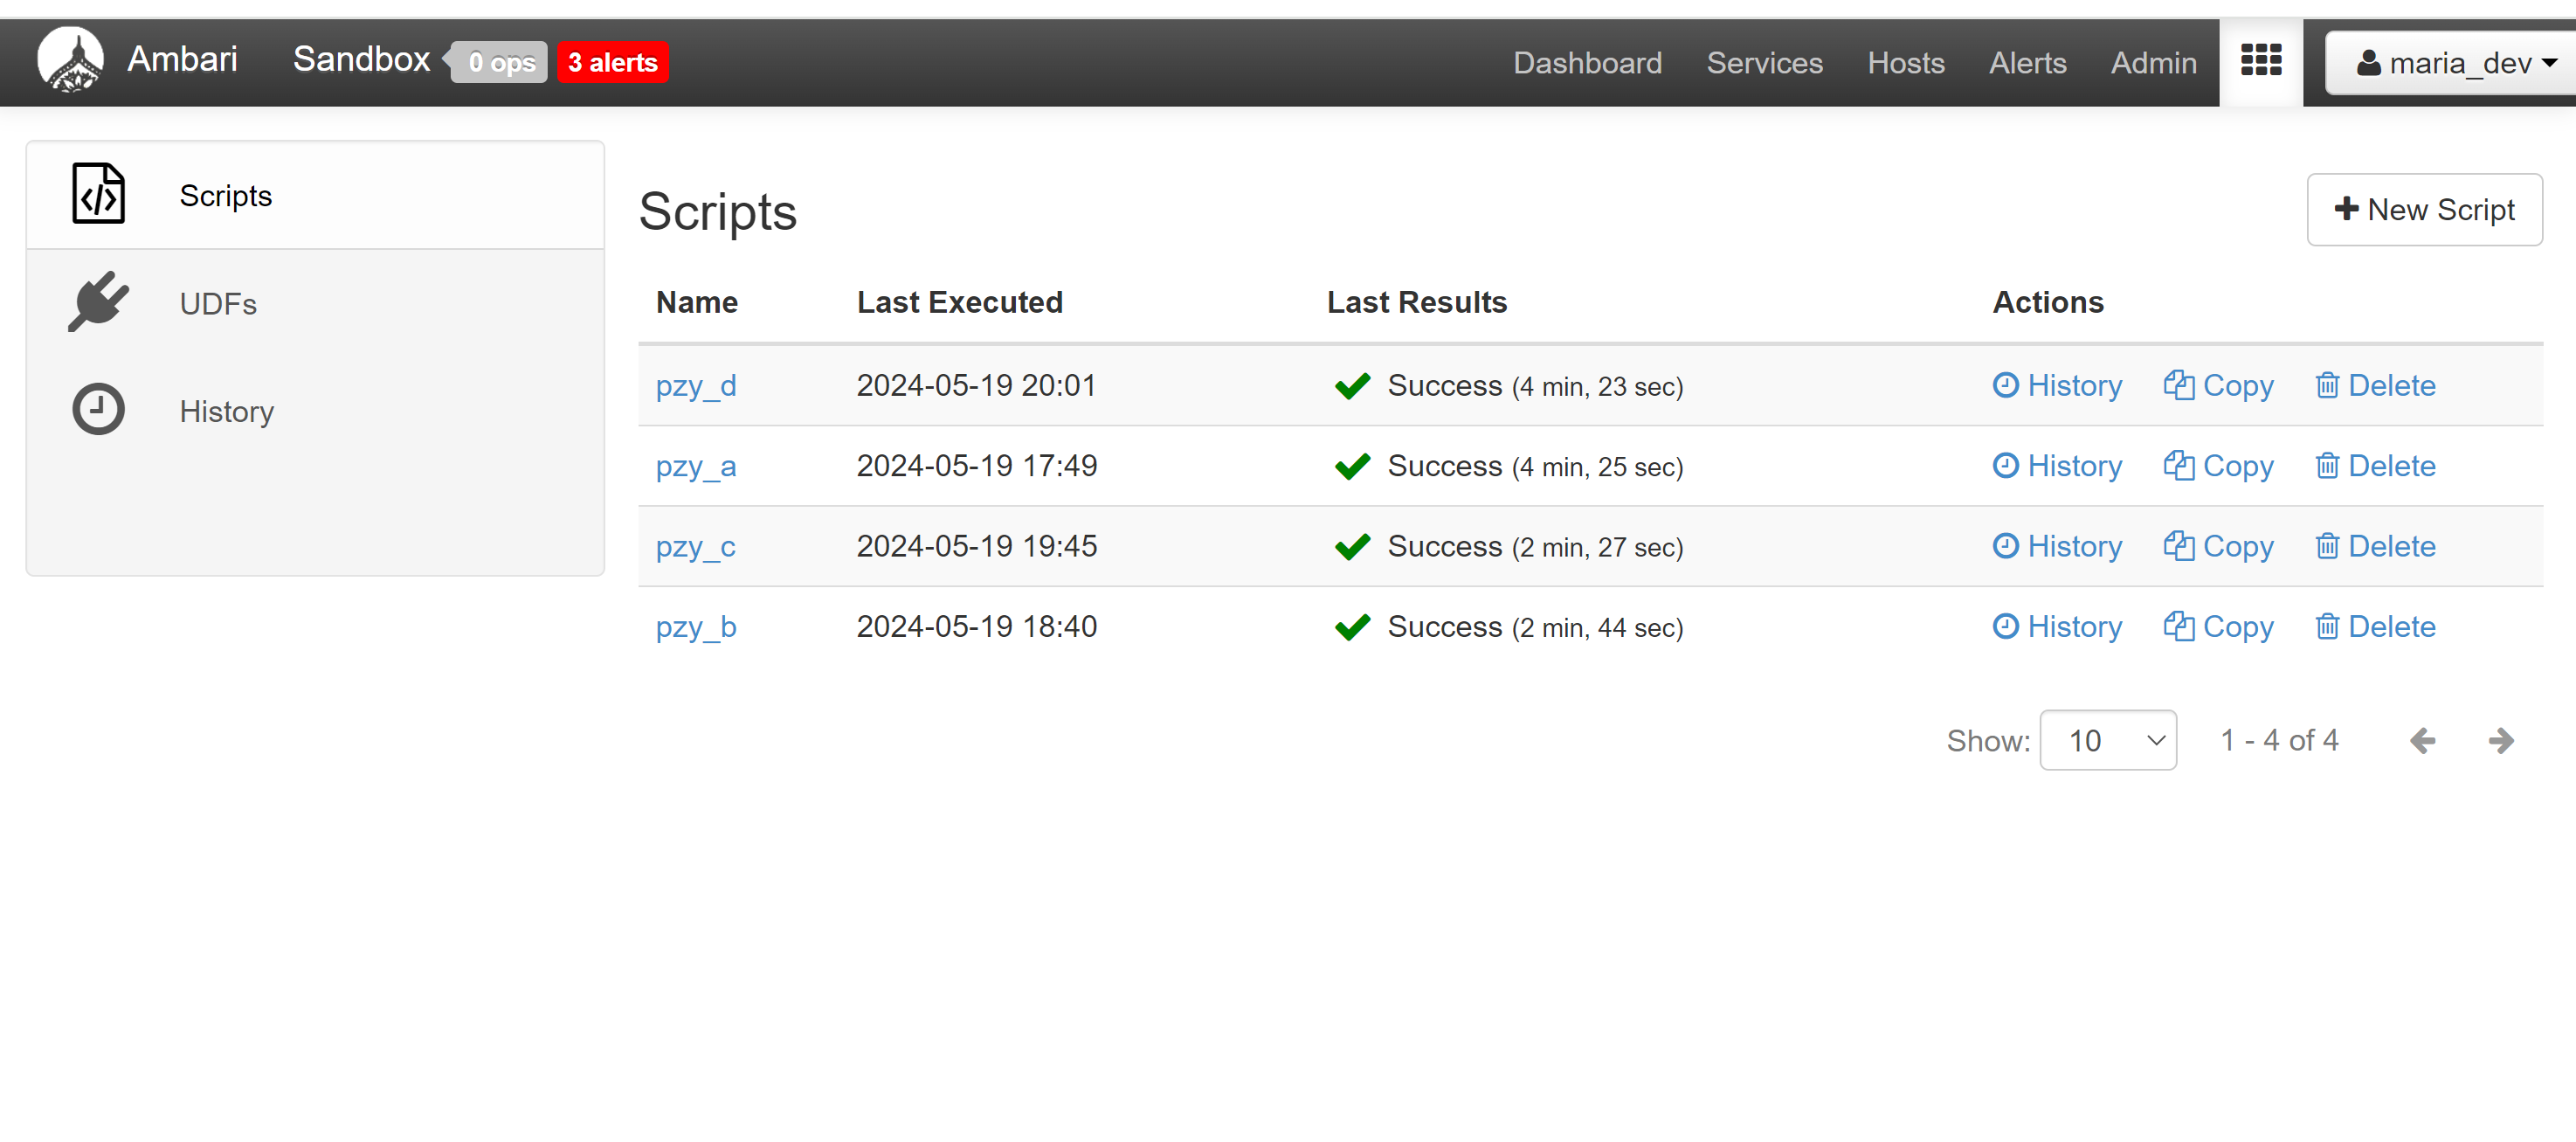

In [1]:
from IPython.display import Image
Image('/content/pig.png', width =700)

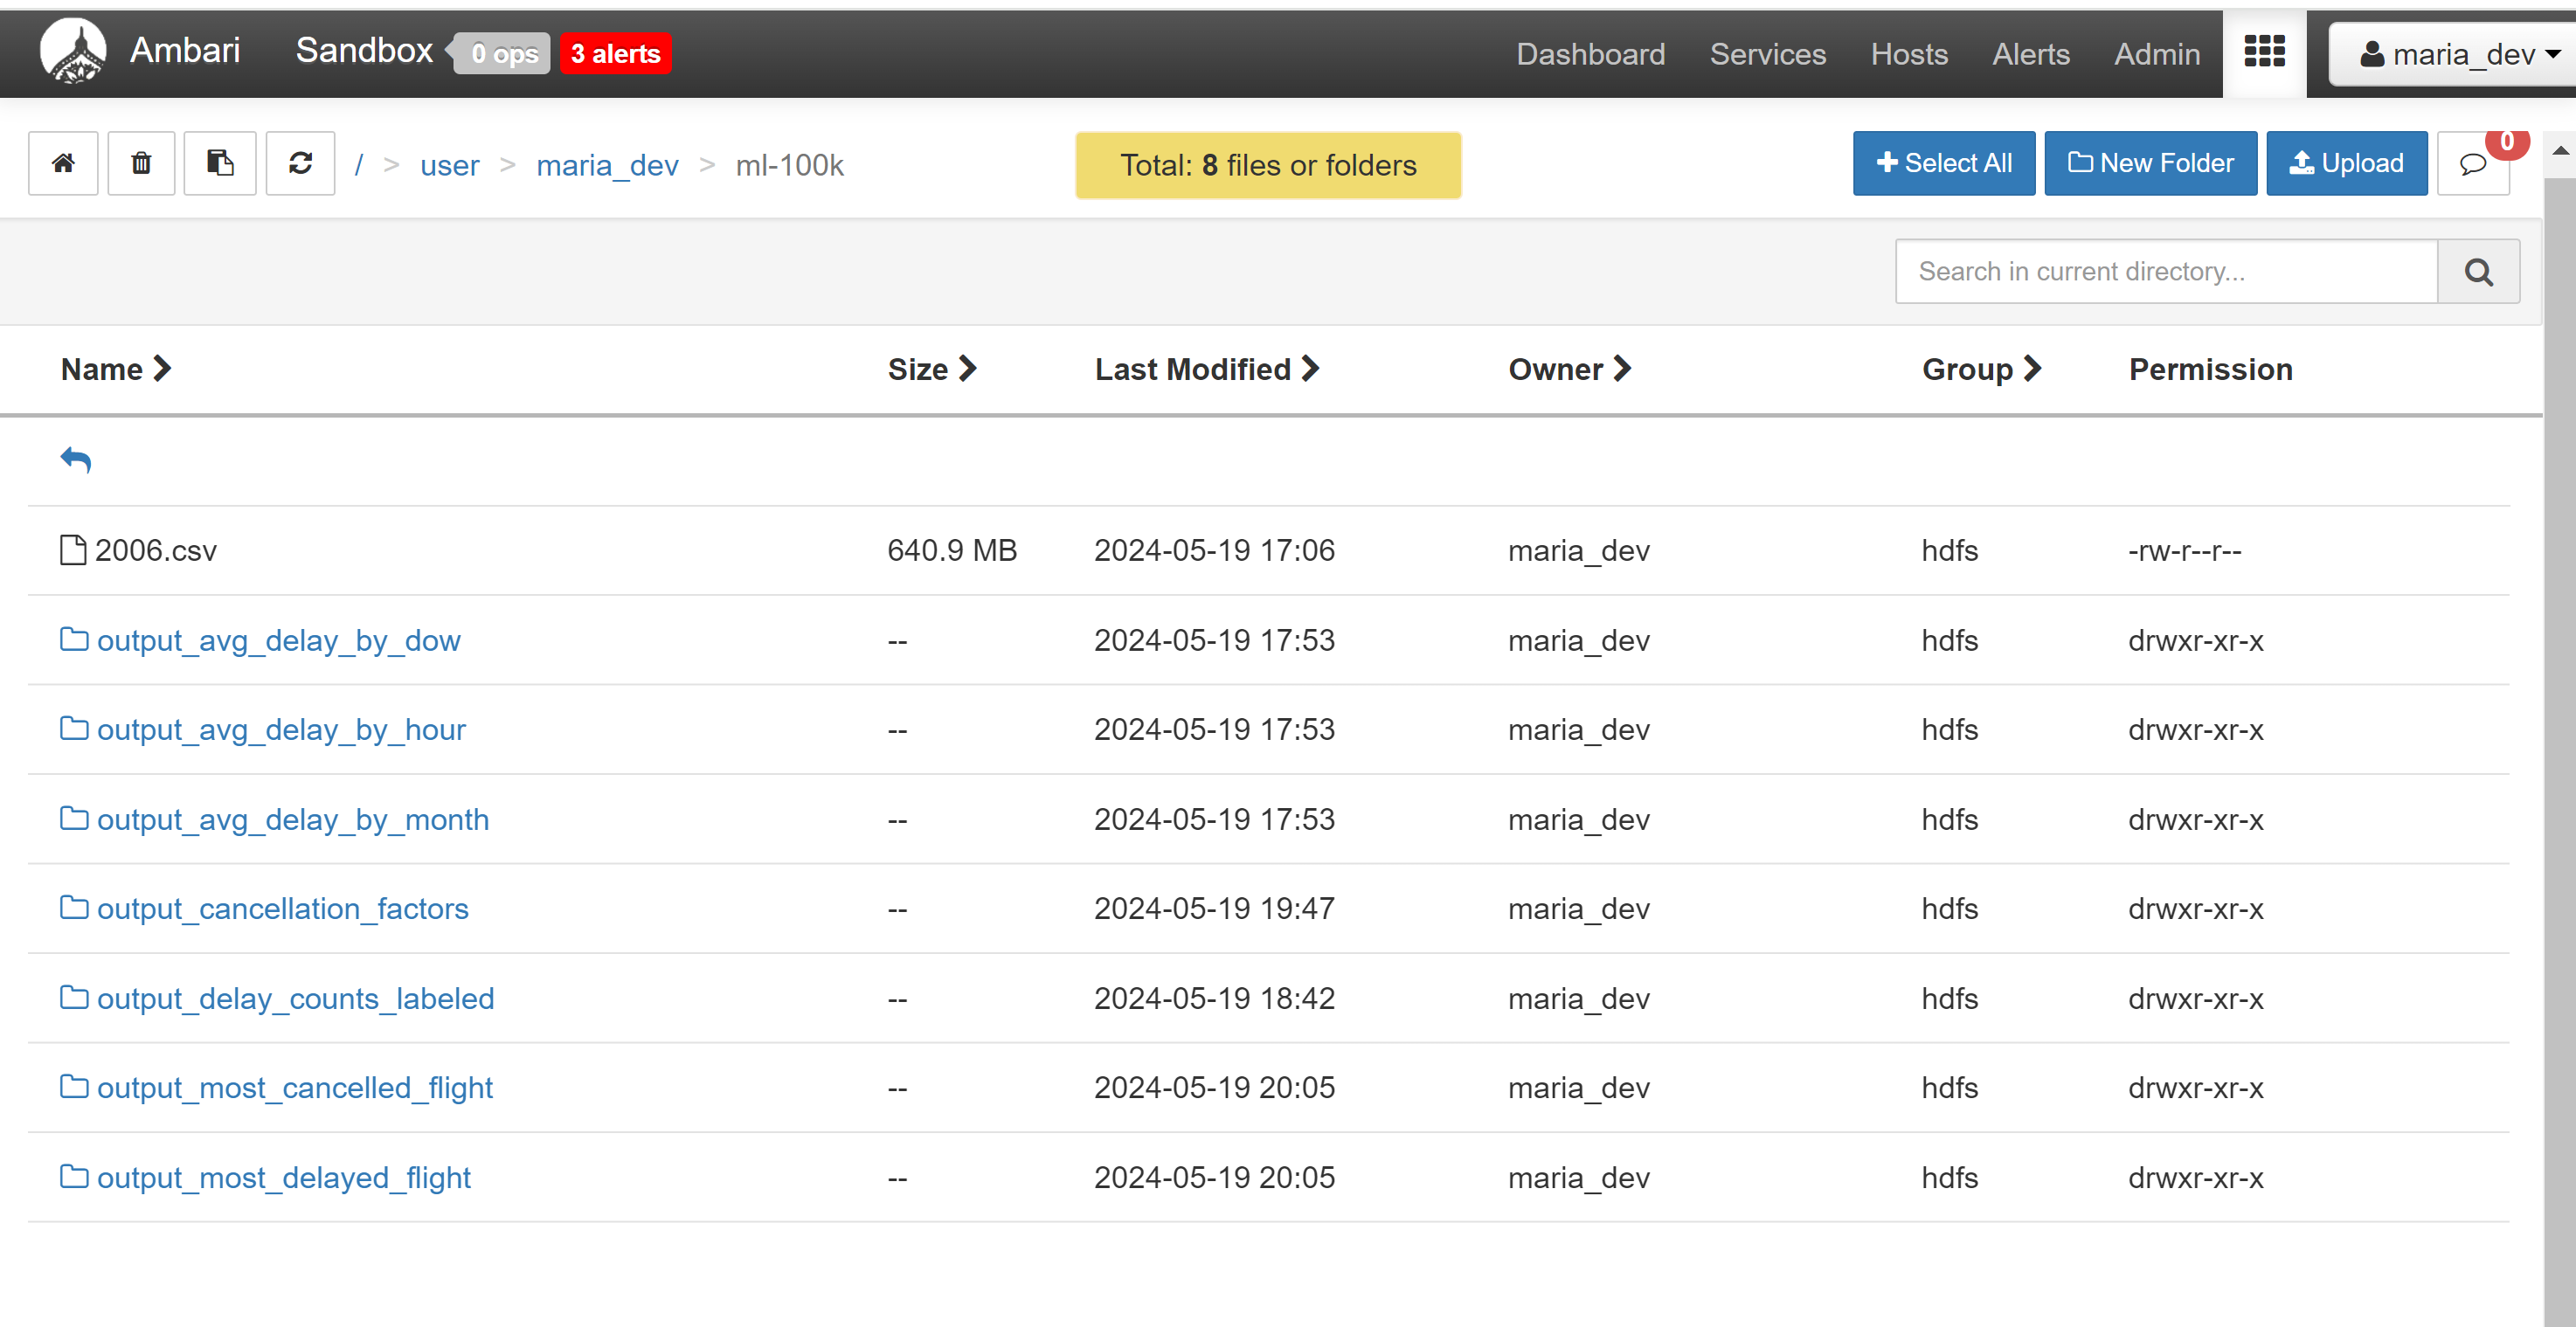

In [2]:
from IPython.display import Image
Image('/content/all.png', width =700)

🤓As shown in the code in assignment2_pzy_code_pig.txt (from: https://github.com/Nefarian1/STQD6324-Data-Management-work/tree/10f5ecdcf66b067f162b7ac2452660f4a3445d14/assignment2), I made a separate script for each question and saved it in the corresponding location.

#Analyze🤓🤓🤓
After the above operation, I exported the result file in .txt format.

https://github.com/Nefarian1/STQD6324-Data-Management-work/tree/1a528843c696099df231bb7014e7ea57cff459b8/assignment2/result_txt

The following is the analysis:

# a 🤓

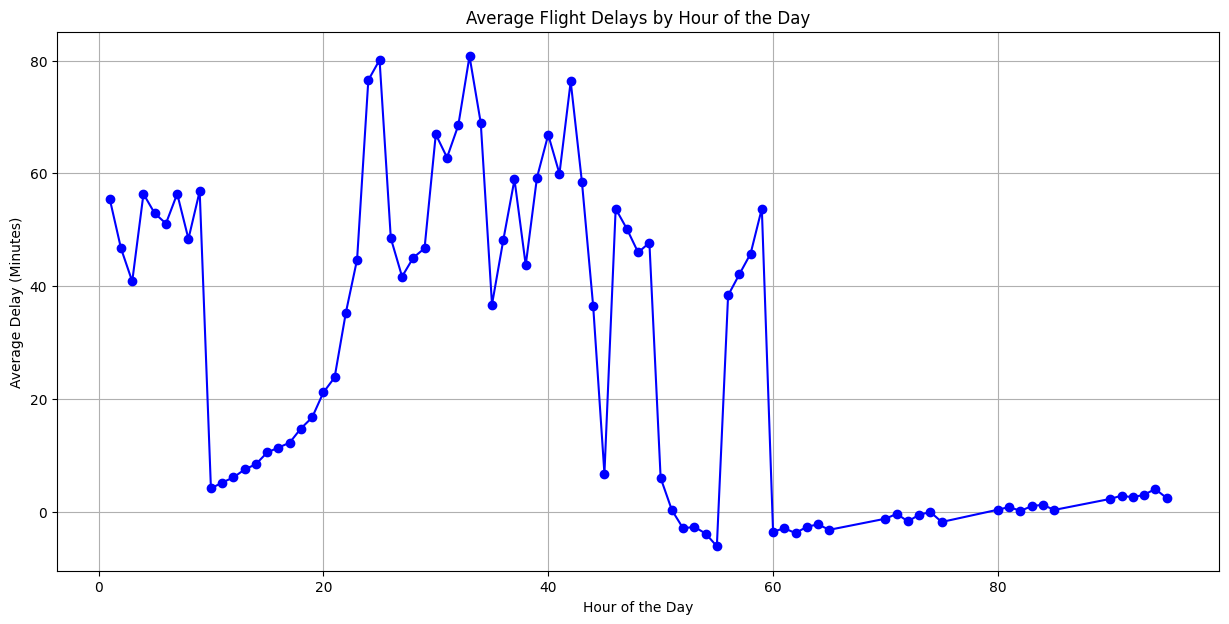

In [3]:
# a1
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
file_path = '/content/a1.txt'
data = pd.read_csv(file_path, header=None, names=['Hour', 'AvgArrDelay'])

# 绘制折线图
plt.figure(figsize=(15, 7))
plt.plot(data['Hour'], data['AvgArrDelay'], marker='o', linestyle='-', color='b')

# 添加图表标题和标签
plt.title('Average Flight Delays by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Delay (Minutes)')

# 显示网格
plt.grid(True)

# 显示图表
plt.show()


It seems that the time period in between is prone to delays

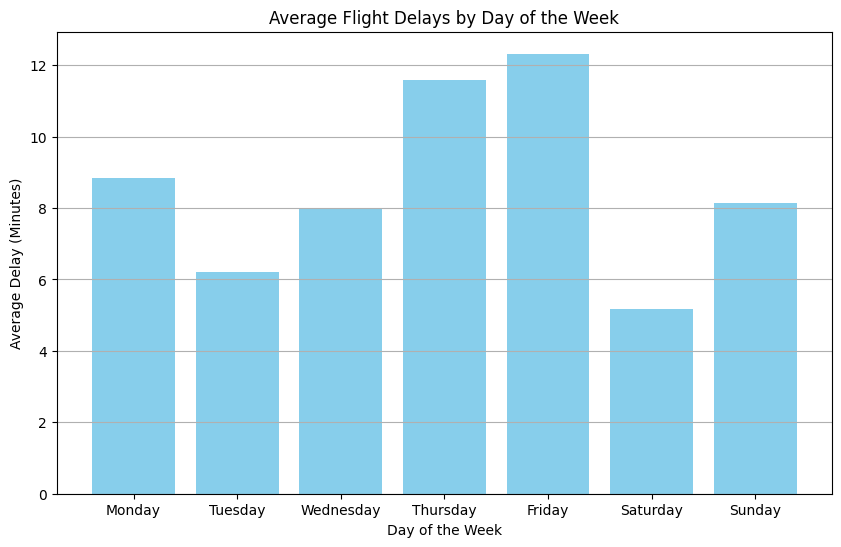

In [7]:
# a2
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
file_path = '/content/a2.txt'
data = pd.read_csv(file_path, header=None, names=['DayOfWeek', 'AvgArrDelay'])

# 映射星期几
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
data['DayOfWeek'] = data['DayOfWeek'].map(day_mapping)

# 设置星期几顺序
data['DayOfWeek'] = pd.Categorical(data['DayOfWeek'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'], ordered=True)

# 按星期几排序
data = data.sort_values('DayOfWeek')

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.bar(data['DayOfWeek'], data['AvgArrDelay'], color='skyblue')

# 添加图表标题和标签
plt.title('Average Flight Delays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (Minutes)')

# 显示网格
plt.grid(axis='y')

# 显示图表
plt.show()


We can intuitively see which day of the week has the longest flight delays. This is important for airlines to optimize flight scheduling and passengers to choose travel dates. Here are the longest delays on Friday.

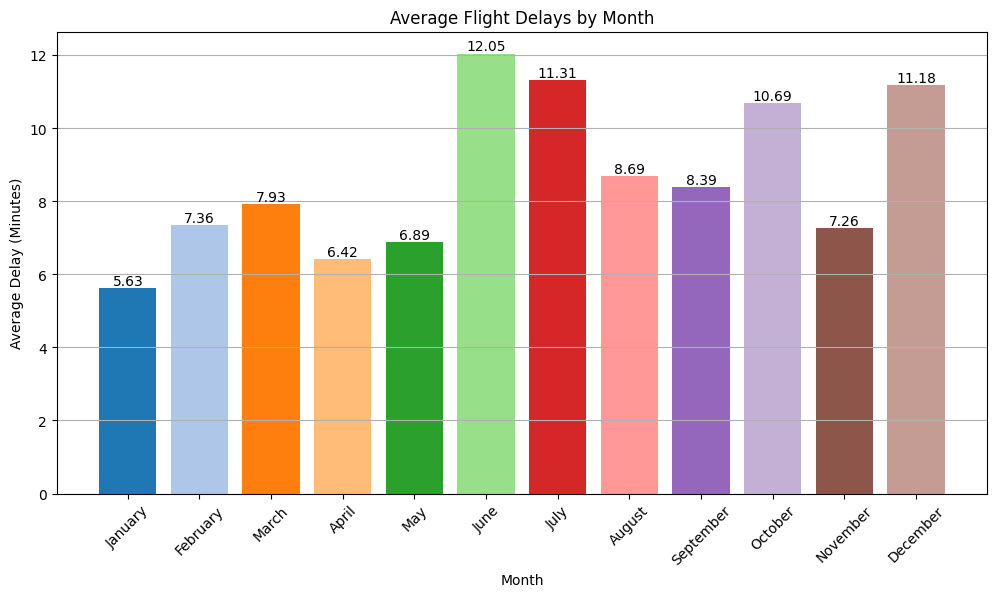

In [6]:
# a3
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
file_path = '/content/a3.txt'
data = pd.read_csv(file_path, header=None, names=['Month', 'AvgArrDelay'])

# 映射月份
month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
data['Month'] = data['Month'].map(month_mapping)

# 设置月份类别顺序
data['Month'] = pd.Categorical(data['Month'], categories=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

# 按月份顺序排序
data = data.sort_values('Month')

# 生成彩色条形图
colors = plt.cm.tab20.colors  # 使用Matplotlib的颜色映射
plt.figure(figsize=(12, 6))
bars = plt.bar(data['Month'], data['AvgArrDelay'], color=colors[:len(data)])

# 添加图表标题和标签
plt.title('Average Flight Delays by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (Minutes)')

# 显示数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# 显示网格
plt.grid(axis='y')

# 显示图表
plt.xticks(rotation=45)  # X轴标签旋转以避免重叠
plt.show()


It looks like the delays will be the worst in June.

# b 🤓

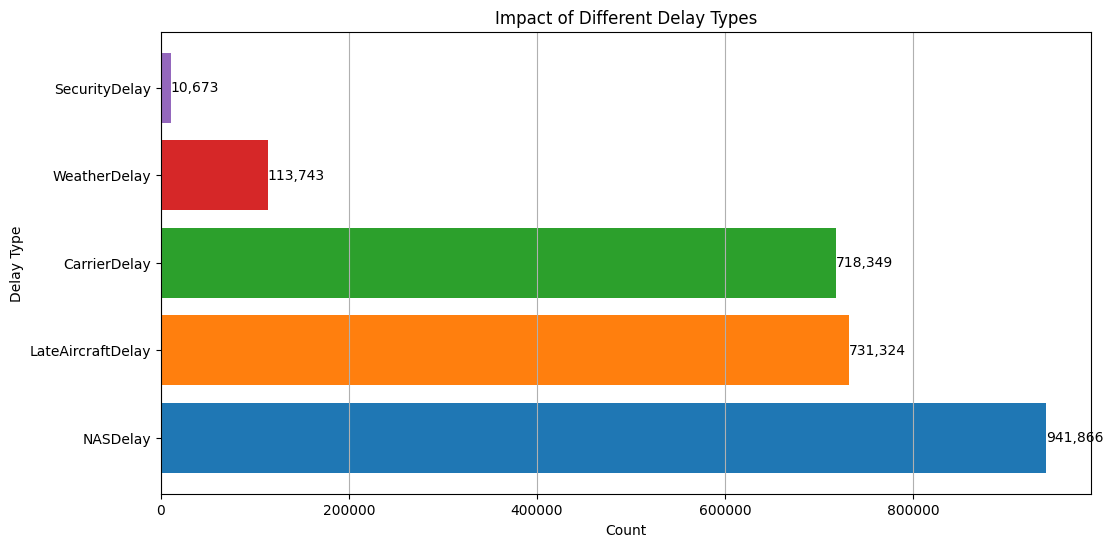

In [8]:
# b
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
file_path = '/content/b.txt'
data = pd.read_csv(file_path, header=None, names=['DelayType', 'Count'])

# 按影响大小排序
data = data.sort_values('Count', ascending=False)

# 生成彩色水平条形图
colors = plt.cm.tab10.colors  # 使用Matplotlib的颜色映射
plt.figure(figsize=(12, 6))
bars = plt.barh(data['DelayType'], data['Count'], color=colors[:len(data)])

# 添加图表标题和标签
plt.title('Impact of Different Delay Types')
plt.xlabel('Count')
plt.ylabel('Delay Type')

# 显示数值标签
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:,}', ha='left', va='center')

# 显示网格
plt.grid(axis='x')

# 显示图表
plt.show()


It seems that NASDelay is the most common. NASDelay (National Airspace System Delay) refers to flight delays caused by the national airspace system. This delay is usually caused by air traffic control, airport capacity constraints, air traffic flow management plans, runway closures, flight route congestion, etc.

# c 🤓

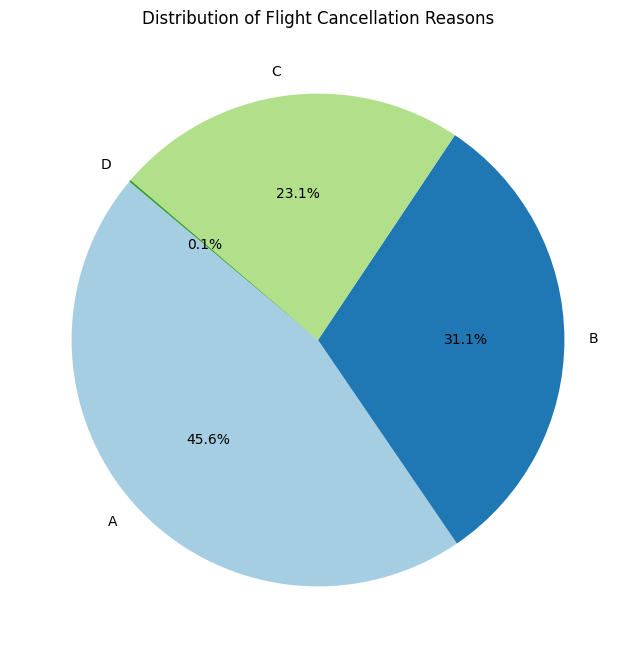

In [9]:
# c
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
file_path = '/content/c.txt'
data = pd.read_csv(file_path, header=None, names=['CancellationCode', 'Count'])

# 生成彩色圆饼图
plt.figure(figsize=(8, 8))
colors = plt.cm.Paired.colors  # 使用不同的颜色映射
plt.pie(data['Count'], labels=data['CancellationCode'], autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Distribution of Flight Cancellation Reasons')

# 显示图表
plt.show()


The most common reason for flight cancellation is type A. However, I don't know what these types mean.

# d 🤓

In [11]:
# d1
import subprocess

file_path = '/content/d1.txt'

# 执行head命令并获取结果
result = subprocess.run(['head', file_path], stdout=subprocess.PIPE, text=True)

# 打印结果
print(result.stdout)

WN,493,1031,4,11.471830985915492



The most delayed flights
+ 航空公司代码（Airline Code）: WN
+ 航班号（Flight Number）: 493
+ 延误次数（Delay Count）: 1031
+ 取消次数（Cancellation Count）: 4
+ 平均延误时间（Average Delay Time）: 11.471830985915492

In [12]:
# d2
import subprocess

file_path = '/content/d2.txt'

# 执行head命令并获取结果
result = subprocess.run(['head', file_path], stdout=subprocess.PIPE, text=True)

# 打印结果
print(result.stdout)

WN,20,96,94,2.237942122186495



The most cancelled flights
+ 航空公司代码（Airline Code）: WN
+ 航班号（Flight Number）: 20
+ 延误次数（Delay Count）: 96
+ 取消次数（Cancellation Count）: 94
+ 平均延误时间（Average Delay Time）: 2.237942122186495